In [1]:
import itertools
import pandas
import numpy
import glob
import tqdm
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt


In [2]:
# settings
protocols = ['fotb', 'totb', 'htlltb', 'htlltbtest']
n_processes = [3, 6, 9, 12]
workload_time = 180
prefixes = [str(a) + "-" + str(b) for a,b in itertools.product(protocols, n_processes)]
colours = ["r", "g", "b", "k"]
markers = ["o", "v", "^", "x"]
linestyles = ['-','--',':','-.']


In [3]:
# check data
print("number of log files: %s" % len(glob.glob('../data/*.log')))
print("expected number of log files: %s" % (len(protocols) * sum(n_processes)))


number of log files: 120
expected number of log files: 120


In [4]:
# preprocessing
results = []

# for each prefix (i.e. benchmark run): fotb-3, ..., htlltbtest-12
for prefix in tqdm.tqdm(prefixes):
    # merge all logs for a prefix into a dataframe df, normalizing the time of each
    # individual history to the minimum time of that history.
    # ignore lines that start with { as these are error messages.
    # first line is the header line.
    # calculate the latency of a broadcast message, as the time difference between 
    # the broadcast and delivery of that message.
    # from the merged logs, we calculate summarizing statistics, 
    # and provide these for each prefix.
    files = glob.glob('../data/' + prefix + '*')
    df = []
    for file in files:
        d = pandas.read_csv(files[0], sep=' ', comment="{") 
        d["t"] = d["time"] - d["time"].min()
        d["prefix"] = prefix
        d["file"] = file
        d = pandas.merge(d, d[d["operation"] == "deliver"], on=["processid", "messagenumber"], how="left", suffixes=('', '_y'))
        d["latency"] = d["t_y"] - d["t"]
        d = d.filter(["prefix", "file", "operation", "processid", "messagenumber", "t", "latency"])
        df.append(d)
    df = pandas.concat(df)
    average_throughput_time_series = pandas.DataFrame(pandas.DataFrame(df[(df["operation"] == "deliver") & (df["t"] < workload_time)]["t"].astype(int)).groupby("t").size()).reset_index().rename({0: "throughput"}, axis=1)
    average_throughput_time_series["throughput"] = average_throughput_time_series["throughput"] / float(df["file"].unique().shape[0])
    average_throughput_time_series = average_throughput_time_series.merge(pandas.DataFrame(range(180), columns=["t"]), on="t", how="right", sort=True).fillna(0.0)
    average_latency_time_series = pandas.DataFrame(pandas.DataFrame(df[(df["operation"] == "broadcast") & (df["t"] < workload_time)])).astype({'t': 'int'}).filter(["t", "latency"]).groupby("t").mean().reset_index()
    result = {
        "prefix": prefix,
        'throughput_mean': df[ df["operation"] == "deliver"].shape[0] / (workload_time * df["file"].unique().shape[0]),
        'nodes': df["file"].unique().shape[0],
        'average_throughput_time_series': average_throughput_time_series,
        'latency_mean': df[ df["operation"] == "broadcast"]["latency"].mean(),
        'latency_std': df[ df["operation"] == "broadcast"]["latency"].std(),
        "latency_5th_quantile": df[ df["operation"] == "broadcast"]["latency"].quantile(q=0.05),
        "latency_95th_quantile": df[ df["operation"] == "broadcast"]["latency"].quantile(q=0.95),
        'average_latency_time_series': average_latency_time_series,
    }
    results.append(result)
results = pandas.DataFrame(results)
results


100%|██████████| 16/16 [10:06<00:00, 37.90s/it]


,prefix,throughput_mean,nodes,average_throughput_time_series,latency_mean,latency_std,latency_5th_quantile,latency_95th_quantile,average_latency_time_series
0,fotb-3,526.716667,3,t throughput 0 0 0.0 1 ...,9.722530,2.795360,5.943106,15.668186,t latency 0 0 17.518412 1 ...
1,fotb-6,860.727778,6,t throughput 0 0 0.0 1 ...,53.798401,19.337419,14.412870,78.946239,t latency 0 0 5.895746 1 ...
2,fotb-9,926.750000,9,t throughput 0 0 0.0 1 ...,33.160583,11.429362,14.038608,50.176561,t latency 0 0 12.255514 1 ...
3,fotb-12,257.766667,12,t throughput 0 0 0.0 1 ...,9.102587,3.943353,4.151560,17.465472,t latency 0 0 10.051417 1 ...
4,totb-3,160.233333,3,t throughput 0 0 0.0 1 ...,70.490999,5.459325,60.611843,78.753315,t latency 0 0 65.287922 1 ...
5,totb-6,496.055556,6,t throughput 0 0 0.0 1 ...,89.389918,7.555219,76.129091,101.438253,t latency 0 0 74.739568 1 ...
6,totb-9,517.322222,9,t throughput 0 0 0.0 1 ...,101.771298,15.333955,78.802275,123.425698,t latency 0 0 66.602975 1 ...
7,totb-12,543.583333,12,t throughput 0 0 0.0 1 ...,96.840378,15.834513,67.538895,117.008088,t latency 0 0 66.247277 1 ...
8,htlltb-3,4534.044444,3,t throughput 0 0 5632.0 1 ...,0.070446,0.031779,0.030087,0.130233,t latency 0 0 0.065266 1 1...
9,htlltb-6,7441.777778,6,t throughput 0 0 5109.0 1 ...,0.073550,0.038643,0.027509,0.146589,t latency 0 0 0.081541 1 1...


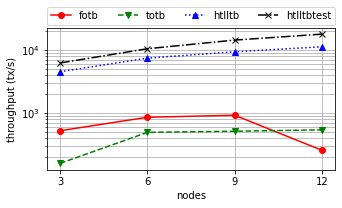

In [14]:
# throughput
plt.figure(figsize=(1.618 * 3, 3))

for protocol, col, marker, ls in zip(protocols, colours, markers, linestyles):
    r = results[results["prefix"].str.contains(protocol+"-")]
    plt.plot(r["nodes"], r["throughput_mean"], label=protocol, marker=marker, c=col, ls=ls)

plt.xticks([3, 6, 9, 12])
plt.ylabel("throughput (tx/s)")
plt.xlabel("nodes")
plt.title(" ")
plt.yscale("log")
plt.grid(which="both", linestyle='-')
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=4)

plt.tight_layout()
plt.savefig("../reports/throughput.pdf")


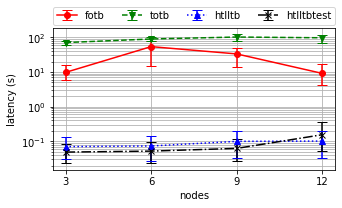

In [15]:
# latency plot with 5th and 95th quantile
plt.figure(figsize=(1.618 * 3, 3))

for protocol, col, marker, ls in zip(protocols, colours, markers, linestyles):
    r = results[results["prefix"].str.contains(protocol+"-")]
    plt.errorbar(
        r["nodes"], 
        r["latency_mean"], 
        [
            r["latency_mean"] - r["latency_5th_quantile"], 
            r["latency_95th_quantile"] - r["latency_mean"]], 
        c=col,
        label=protocol,
        capsize=5,
        marker=marker,
        ls=ls,
    )

plt.xticks([3, 6, 9, 12])
plt.ylabel("latency (s)")
plt.xlabel("nodes")
plt.yscale("log")
plt.grid(which="both", linestyle='-')
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=4)

plt.tight_layout()
plt.savefig("../reports/latency.pdf")


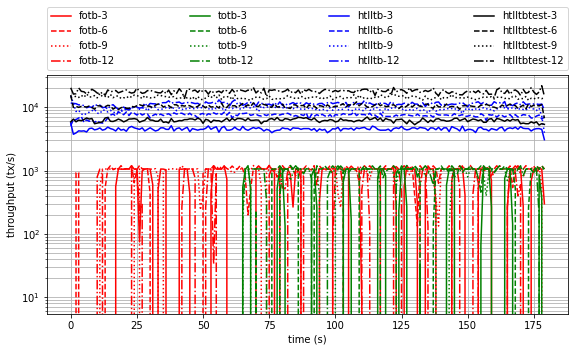

In [16]:
# throughput time series
plt.figure(figsize=(1.618 * 5, 5))

for protocol, col, marker in zip(protocols, colours, markers):
    r = results[results["prefix"].str.contains(protocol+"-")]
    for (idx, row), ls in zip(r.iterrows(), linestyles):
        plt.plot(row["average_throughput_time_series"]["t"], row["average_throughput_time_series"]["throughput"], label=row["prefix"], c=col, linestyle=ls)

plt.ylabel("throughput (tx/s)")
plt.xlabel("time (s)")
plt.yscale("log")
plt.grid(which="both", linestyle='-')
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=4)

plt.tight_layout()


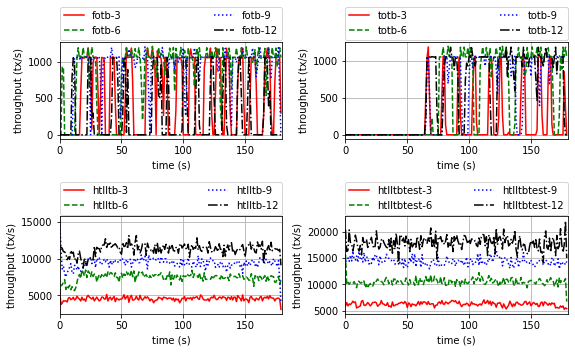

In [17]:
# throughput time series
fig, axs = plt.subplots(2, 2, figsize=(1.618 * 5, 5), sharex=True)
axs = numpy.ravel(axs)

for i, (protocol) in enumerate(protocols):
    r = results[results["prefix"].str.contains(protocol+"-")]
    for (idx, row), ls, c in zip(r.iterrows(), linestyles, colours):
        axs[i].plot(row["average_throughput_time_series"]["t"], row["average_throughput_time_series"]["throughput"], label=row["prefix"], c=c, linestyle=ls)

    axs[i].set_ylabel("throughput (tx/s)")
    axs[i].set_xlabel("time (s)")
    axs[i].set_xlim(0, workload_time)
    axs[i].grid(which="both", linestyle='-')
    axs[i].xaxis.set_tick_params(which='both', labelbottom=True)
    axs[i].legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=2)

plt.tight_layout()
plt.savefig("../reports/throughputtimeseries.pdf")


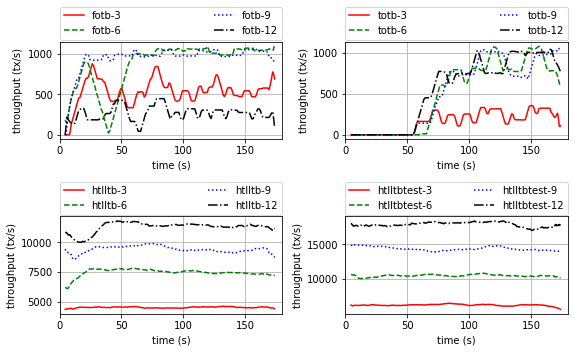

In [18]:
# throughput time series - rolling average over 30-second-window
fig, axs = plt.subplots(2, 2, figsize=(1.618 * 5, 5), sharex=True)
axs = numpy.ravel(axs)

for i, (protocol, col, marker) in enumerate(zip(protocols, colours, markers)):
    r = results[results["prefix"].str.contains(protocol+"-")]
    for (idx, row), ls, c in zip(r.iterrows(), linestyles, colours):
        rz = row["average_throughput_time_series"].rolling(window=20, min_periods=0, center=True).mean()
        axs[i].plot(rz["t"], rz["throughput"], label=row["prefix"], c=c, linestyle=ls)
    axs[i].set_ylabel("throughput (tx/s)")
    axs[i].set_xlabel("time (s)")
    axs[i].set_xlim(0, workload_time)
    axs[i].grid(which="both", linestyle='-')
    axs[i].xaxis.set_tick_params(which='both', labelbottom=True)
    axs[i].legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=2)

plt.tight_layout()
plt.savefig("../reports/throughputtimeseriessmooth.pdf")


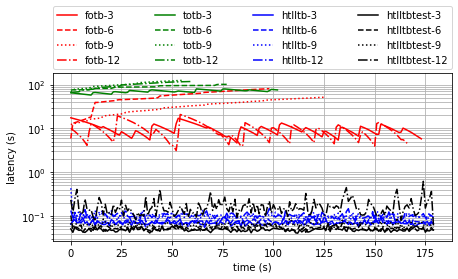

In [19]:
# latency time series
plt.figure(figsize=(1.618 * 4, 4))

for protocol, col, marker in zip(protocols, colours, markers):
    r = results[results["prefix"].str.contains(protocol+"-")]
    for (idx, row), ls in zip(r.iterrows(), linestyles):
        plt.plot(row["average_latency_time_series"]["t"], row["average_latency_time_series"]["latency"], label=row["prefix"], c=col, linestyle=ls)

plt.ylabel("latency (s)")
plt.xlabel("time (s)")
plt.yscale("log")
plt.grid(which="both", linestyle='-')
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=4)

plt.tight_layout()


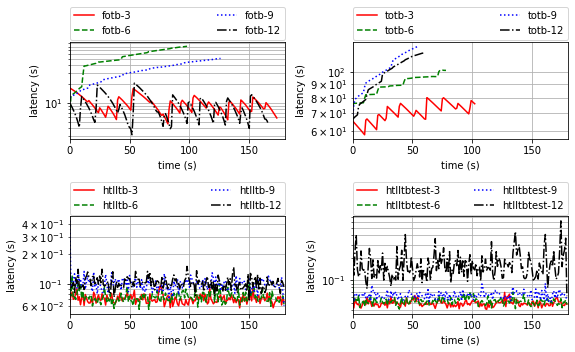

In [20]:
# latency time series
fig, axs = plt.subplots(2, 2, figsize=(1.618 * 5, 5), sharex=True)
axs = numpy.ravel(axs)

for i, protocol in enumerate(protocols):
    r = results[results["prefix"].str.contains(protocol+"-")]
    for (idx, row), ls, c in zip(r.iterrows(), linestyles, colours):
        axs[i].plot(row["average_latency_time_series"]["t"], row["average_latency_time_series"]["latency"], label=row["prefix"], c=c, linestyle=ls)

    axs[i].set_ylabel("latency (s)")
    axs[i].set_xlabel("time (s)")
    axs[i].set_yscale("log")
    axs[i].set_xlim(0, workload_time)
    axs[i].grid(which="both", linestyle='-')
    axs[i].xaxis.set_tick_params(which='both', labelbottom=True)
    axs[i].legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=2)

plt.tight_layout()
plt.savefig("../reports/latencytimeseries.pdf")


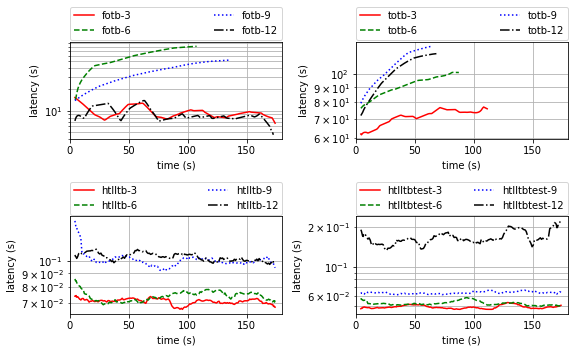

In [21]:
# latency time series - rolling average over 30-second-window
fig, axs = plt.subplots(2, 2, figsize=(1.618 * 5, 5), sharex=True)
axs = numpy.ravel(axs)

for i, protocol in enumerate(protocols):
    r = results[results["prefix"].str.contains(protocol+"-")]
    for (idx, row), ls, c in zip(r.iterrows(), linestyles, colours):
        rz = row["average_latency_time_series"].rolling(window=20, min_periods=0, center=True).mean()
        axs[i].plot(rz["t"], rz["latency"], label=row["prefix"], c=c, linestyle=ls)
        
    axs[i].set_ylabel("latency (s)")
    axs[i].set_xlabel("time (s)")
    axs[i].set_yscale("log")
    axs[i].set_xlim(0, workload_time)
    axs[i].grid(which="both", linestyle='-')
    axs[i].xaxis.set_tick_params(which='both', labelbottom=True)
    axs[i].legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=2)

plt.tight_layout()
plt.savefig("../reports/latencytimeseriessmooth.pdf")


In [22]:
results.filter([
    "prefix",
    "nodes", 
    "throughput_mean",
    "latency_mean",
    "latency_std",
    "latency_5th_quantile",
    "latency_95th_quantile"
])


,prefix,nodes,throughput_mean,latency_mean,latency_std,latency_5th_quantile,latency_95th_quantile
0,fotb-3,3,526.716667,9.722530,2.795360,5.943106,15.668186
1,fotb-6,6,860.727778,53.798401,19.337419,14.412870,78.946239
2,fotb-9,9,926.750000,33.160583,11.429362,14.038608,50.176561
3,fotb-12,12,257.766667,9.102587,3.943353,4.151560,17.465472
4,totb-3,3,160.233333,70.490999,5.459325,60.611843,78.753315
5,totb-6,6,496.055556,89.389918,7.555219,76.129091,101.438253
6,totb-9,9,517.322222,101.771298,15.333955,78.802275,123.425698
7,totb-12,12,543.583333,96.840378,15.834513,67.538895,117.008088
8,htlltb-3,3,4534.044444,0.070446,0.031779,0.030087,0.130233
9,htlltb-6,6,7441.777778,0.073550,0.038643,0.027509,0.146589
